# **OCD Patient Dataset: Demographics & Clinical Data**


## **1. Objective**
The goal of this project is to perform an exploratory data analysis (EDA) on a dataset
containing demographic and clinical data of OCD patients. The analysis will focus on
understanding the relationships between various demographic factors and clinical
outcomes.
## **2. Dataset Overview**
The dataset includes the following columns:
* Patient ID: Unique identifier for each patient.
* Age: Age of the patient.
* Gender: Gender of the patient.
* Ethnicity: Ethnicity of the patient.
* Marital Status: Marital status of the patient.
* Education Level: Level of education attained by the patient.
* OCD Diagnosis Date: Date when OCD was diagnosed.
* Duration of Symptoms (months): Duration for which the patient has
been experiencing symptoms.
* Previous Diagnoses: Any previous diagnoses before OCD.
* Family History of OCD: Whether the patient has a family history of OCD.
* Obsession Type: Type of obsessions experienced by the patient.
* Compulsion Type: Type of compulsions experienced by the patient.
* Y-BOCS Score (Obsessions): Y-BOCS score related to obsessions.
* Y-BOCS Score (Compulsions): Y-BOCS score related to compulsions.
* Depression Diagnosis: Whether the patient has been diagnosed with
depression.
* Anxiety Diagnosis: Whether the patient has been diagnosed with anxiety.
* Medications: Medications the patient is currently taking.

## **Importing Libraries**

In [9]:
!pip install optuna
!pip install eli5
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [10]:
import os
import gc
import random
import base64
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

from scipy import stats
from scipy.stats import norm, skew

from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold
)
from sklearn.preprocessing import LabelEncoder

import optuna
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option("display.max_columns", None)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## **Data Collection & Understanding**

In [11]:
# Collecting the data from CSV file.
data = pd.read_csv("OCD_dataset.csv")
data.head()

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


In [12]:
# Display the columns quantity and names
print('The dataset has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The dataset has 1500 rows and 17 columns


In [13]:
# Understading the columns from the data.
print(data.columns)

Index(['Patient ID', 'Age', 'Gender', 'Ethnicity', 'Marital Status',
       'Education Level', 'OCD Diagnosis Date',
       'Duration of Symptoms (months)', 'Previous Diagnoses',
       'Family History of OCD', 'Obsession Type', 'Compulsion Type',
       'Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)',
       'Depression Diagnosis', 'Anxiety Diagnosis', 'Medications'],
      dtype='object')


In [14]:
# Data info.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Patient ID                     1500 non-null   int64 
 1   Age                            1500 non-null   int64 
 2   Gender                         1500 non-null   object
 3   Ethnicity                      1500 non-null   object
 4   Marital Status                 1500 non-null   object
 5   Education Level                1500 non-null   object
 6   OCD Diagnosis Date             1500 non-null   object
 7   Duration of Symptoms (months)  1500 non-null   int64 
 8   Previous Diagnoses             1252 non-null   object
 9   Family History of OCD          1500 non-null   object
 10  Obsession Type                 1500 non-null   object
 11  Compulsion Type                1500 non-null   object
 12  Y-BOCS Score (Obsessions)      1500 non-null   int64 
 13  Y-B

In [15]:
# Data Description.
data.describe(include = 'all')

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
count,1500.000000,1500.000000,1500,1500,1500,1500,1500,1500.000000,1252,1500,1500,1500,1500.000000,1500.00000,1500,1500,1114
unique,NaN,NaN,2,4,3,4,1218,NaN,4,2,5,5,NaN,NaN,2,2,3
top,NaN,NaN,Male,Caucasian,Single,Some College,2017-06-21,NaN,MDD,Yes,Harm-related,Washing,NaN,NaN,Yes,Yes,Benzodiazepine
freq,NaN,NaN,753,398,511,394,4,NaN,345,760,333,321,NaN,NaN,772,751,386
mean,5541.254000,46.781333,NaN,NaN,NaN,NaN,NaN,121.745333,NaN,NaN,NaN,NaN,20.048000,19.62600,NaN,NaN,NaN
std,2562.389469,16.830321,NaN,NaN,NaN,NaN,NaN,67.404610,NaN,NaN,NaN,NaN,11.823884,11.78287,NaN,NaN,NaN
min,1017.000000,18.000000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,0.000000,0.00000,NaN,NaN,NaN
25%,3338.000000,32.000000,NaN,NaN,NaN,NaN,NaN,64.000000,NaN,NaN,NaN,NaN,10.000000,9.00000,NaN,NaN,NaN
50%,5539.500000,47.000000,NaN,NaN,NaN,NaN,NaN,121.000000,NaN,NaN,NaN,NaN,20.000000,20.00000,NaN,NaN,NaN
75%,7745.500000,61.000000,NaN,NaN,NaN,NaN,NaN,178.000000,NaN,NaN,NaN,NaN,31.000000,29.00000,NaN,NaN,NaN


### Renaming the columns


In [16]:
data = pd.DataFrame(data)

# Renaming columns
data.rename(columns={
    'Patient ID': 'patient_id',
    'Age': 'age',
    'Gender': 'gender',
    'Ethnicity': 'ethnicity',
    'Marital Status': 'marital_status',
    'Education Level': 'education_level',
    'OCD Diagnosis Date': 'ocd_diagnosis_date',
    'Duration of Symptoms (months)': 'symptom_duration_months',
    'Previous Diagnoses': 'previous_diagnoses',
    'Family History of OCD': 'family_history_ocd',
    'Obsession Type': 'obsession_type',
    'Compulsion Type': 'compulsion_type',
    'Y-BOCS Score (Obsessions)': 'ybocs_obsession_score',
    'Y-BOCS Score (Compulsions)': 'ybocs_compulsion_score',
    'Depression Diagnosis': 'depression_diagnosis',
    'Anxiety Diagnosis': 'anxiety_diagnosis',
    'Medications': 'medications'
}, inplace=True)

# Display updated DataFrame
print(data.columns)

Index(['patient_id', 'age', 'gender', 'ethnicity', 'marital_status',
       'education_level', 'ocd_diagnosis_date', 'symptom_duration_months',
       'previous_diagnoses', 'family_history_ocd', 'obsession_type',
       'compulsion_type', 'ybocs_obsession_score', 'ybocs_compulsion_score',
       'depression_diagnosis', 'anxiety_diagnosis', 'medications'],
      dtype='object')


## **Data Preprocessing**

### Handling missing Values

In [17]:
# Identifing the missing values from the dataset.
print(data.isnull().sum())

patient_id                   0
age                          0
gender                       0
ethnicity                    0
marital_status               0
education_level              0
ocd_diagnosis_date           0
symptom_duration_months      0
previous_diagnoses         248
family_history_ocd           0
obsession_type               0
compulsion_type              0
ybocs_obsession_score        0
ybocs_compulsion_score       0
depression_diagnosis         0
anxiety_diagnosis            0
medications                386
dtype: int64


We have two columns **Previous Diagnoses** & **Medications** with missing values.

In [18]:
data.head()

,patient_id,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,symptom_duration_months,previous_diagnoses,family_history_ocd,obsession_type,compulsion_type,ybocs_obsession_score,ybocs_compulsion_score,depression_diagnosis,anxiety_diagnosis,medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


In [19]:
# 1. Handle missing values
data["previous_diagnoses"].fillna("No_Dignosis", inplace=True)
data["medications"].fillna("No_Medication", inplace=True)

# 2. Convert 'OCD Diagnosis Date' to datetime format
data["ocd_diagnosis_date"] = pd.to_datetime(data["ocd_diagnosis_date"], errors='coerce')

# Check for any remaining missing values
print("\nMissing Values After Handling:")
print(data.isnull().sum())


Missing Values After Handling:
patient_id                 0
age                        0
gender                     0
ethnicity                  0
marital_status             0
education_level            0
ocd_diagnosis_date         0
symptom_duration_months    0
previous_diagnoses         0
family_history_ocd         0
obsession_type             0
compulsion_type            0
ybocs_obsession_score      0
ybocs_compulsion_score     0
depression_diagnosis       0
anxiety_diagnosis          0
medications                0
dtype: int64


### Convert Date & Extract Features

In [20]:
# Convert OCD Diagnosis Date to datetime
data["ocd_diagnosis_date"] = pd.to_datetime(data["ocd_diagnosis_date"], errors="coerce")

# Extract useful features
data["year_dignosis"] = data["ocd_diagnosis_date"].dt.year
data["month_since_dignosis"] = ((pd.to_datetime("today") - data["ocd_diagnosis_date"]).dt.days) // 30

# Display transformed date columns
data[["ocd_diagnosis_date", "year_dignosis", "month_since_dignosis"]].head()

,ocd_diagnosis_date,year_dignosis,month_since_dignosis
0,2016-07-15,2016,104
1,2017-04-28,2017,94
2,2018-02-02,2018,85
3,2014-08-25,2014,127
4,2022-02-20,2022,36


### Encode Categorical Variables

In [21]:
data.columns

Index(['patient_id', 'age', 'gender', 'ethnicity', 'marital_status',
       'education_level', 'ocd_diagnosis_date', 'symptom_duration_months',
       'previous_diagnoses', 'family_history_ocd', 'obsession_type',
       'compulsion_type', 'ybocs_obsession_score', 'ybocs_compulsion_score',
       'depression_diagnosis', 'anxiety_diagnosis', 'medications',
       'year_dignosis', 'month_since_dignosis'],
      dtype='object')

In [22]:
data1 = data.copy()
data1.head()

,patient_id,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,symptom_duration_months,previous_diagnoses,family_history_ocd,obsession_type,compulsion_type,ybocs_obsession_score,ybocs_compulsion_score,depression_diagnosis,anxiety_diagnosis,medications,year_dignosis,month_since_dignosis
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI,2016,104
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,No_Dignosis,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI,2017,94
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine,2018,85
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI,2014,127
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,No_Medication,2022,36


In [23]:
# Encoding categorical columns
data["gender"] = data["gender"].map({"Female": 1, "Male": 2})

data["ethnicity"] = data["ethnicity"].map({
    "African": 1, "Hispanic": 2, "Asian": 3, "Caucasian": 4
})

data["marital_status"] = data["marital_status"].map({
    "Single": 1, "Divorced": 2, "Married": 3
})

data["education_level"] = data["education_level"].map({
    "Some College": 1, "College Degree": 2, "High School": 3, "Graduate Degree": 4
})

data["family_history_ocd"] = data["family_history_ocd"].map({"No": 1, "Yes": 2})

data["obsession_type"] = data["obsession_type"].map({
    "Harm-related": 1, "Contamination": 2, "Symmetry": 3, "Hoarding": 4, "Religious": 5
})

data["compulsion_type"] = data["compulsion_type"].map({
    "Checking": 1, "Washing": 2, "Ordering": 3, "Praying": 4, "Counting": 5
})

data["depression_diagnosis"] = data["depression_diagnosis"].map({"No": 1, "Yes": 2})
data["anxiety_diagnosis"] = data["anxiety_diagnosis"].map({"No": 1, "Yes": 2})

data["medications"] = data["medications"].map({
    "SNRI": 0, "SSRI": 1, "Benzodiazepine": 2, "No_Medication": -1
})  # Assign -1 for missing values (no medication)

data["previous_diagnoses"] = data["previous_diagnoses"].map({
    "MDD": 1, "PTSD": 2, "GAD": 3, "Panic Disorder": 4, "No_Dignosis": 0
})

# Display the processed dataset
display(data)

,patient_id,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,symptom_duration_months,previous_diagnoses,family_history_ocd,obsession_type,compulsion_type,ybocs_obsession_score,ybocs_compulsion_score,depression_diagnosis,anxiety_diagnosis,medications,year_dignosis,month_since_dignosis
0,1018,32,1,1,1,1,2016-07-15,203,1,1,1,1,17,10,2,2,0,2016,104
1,2406,69,2,1,2,1,2017-04-28,180,0,2,1,2,21,25,2,2,1,2017,94
2,1188,57,2,2,2,2,2018-02-02,173,1,1,2,1,3,4,1,1,2,2018,85
3,6200,27,1,2,3,2,2014-08-25,126,2,2,3,2,14,28,2,2,1,2014,127
4,5824,56,1,2,3,3,2022-02-20,168,2,2,4,3,39,18,1,1,-1,2022,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,5374,38,2,2,2,2,2019-01-10,53,1,1,2,2,21,33,2,2,1,2019,74
1496,5013,19,1,2,2,4,2022-09-14,160,3,2,4,4,25,16,2,2,1,2022,29
1497,6089,40,2,3,3,1,2018-03-13,100,0,2,2,5,2,15,2,2,2,2018,84
1498,3808,37,1,4,3,1,2018-04-14,210,3,2,2,2,16,7,2,1,2,2018,83


### Handle Outliers

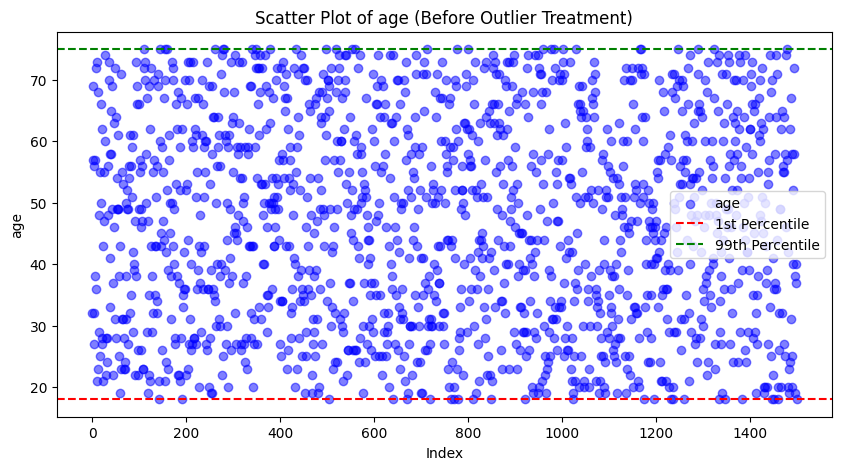

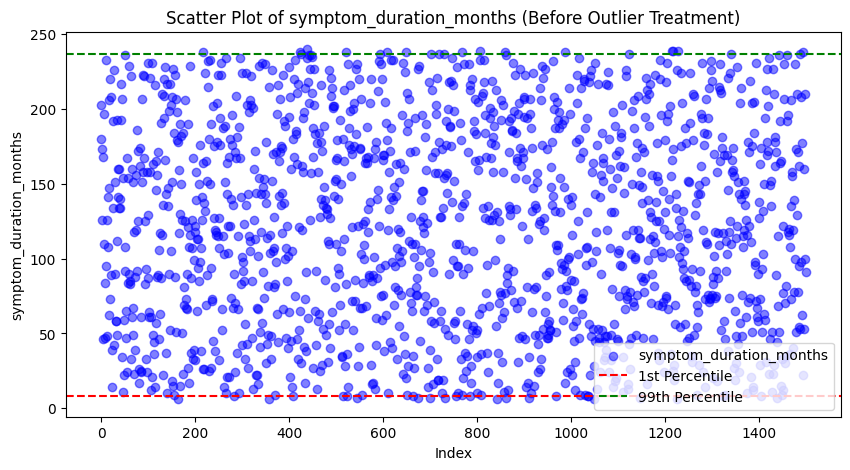

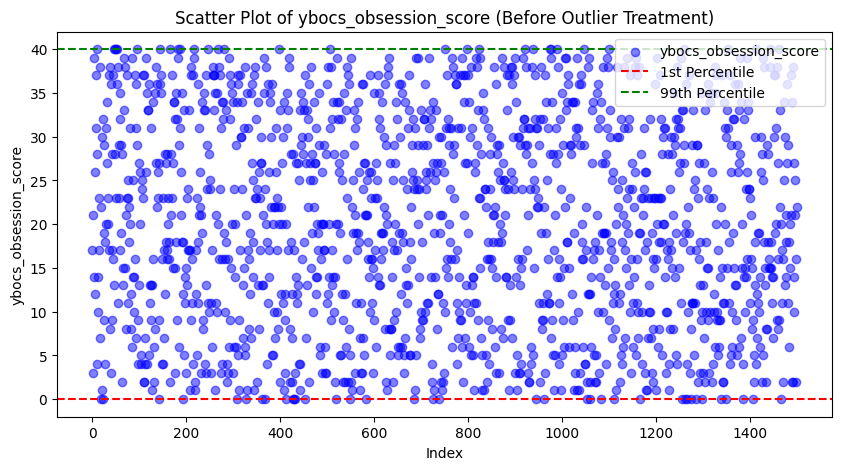

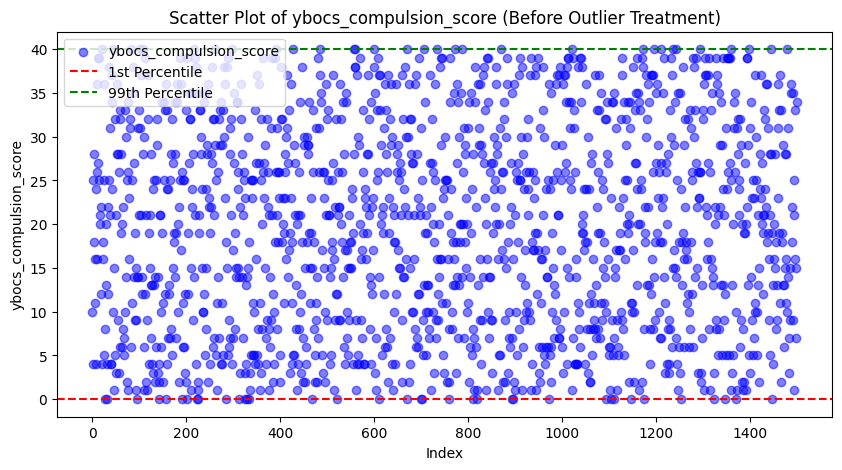

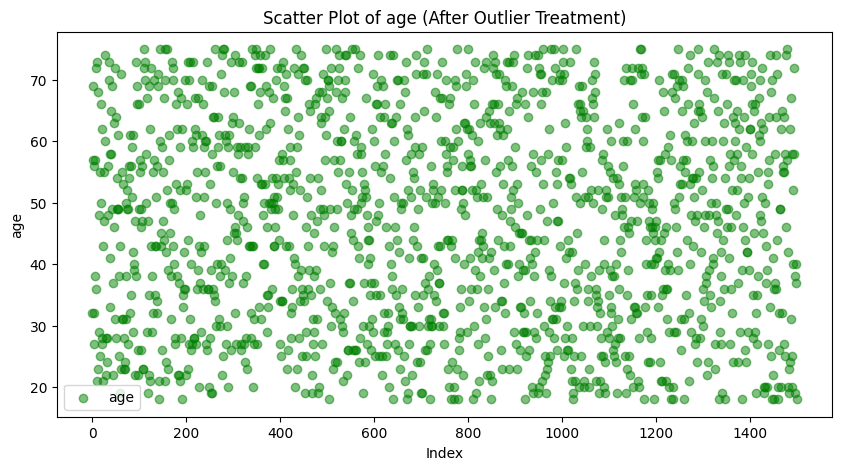

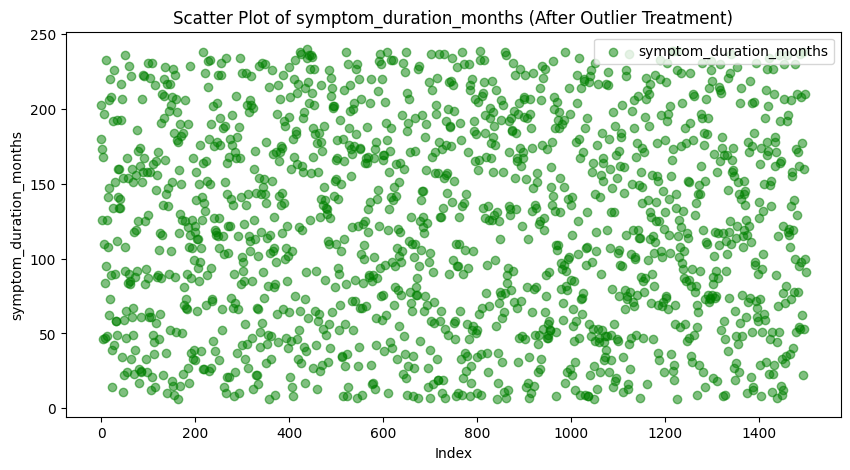

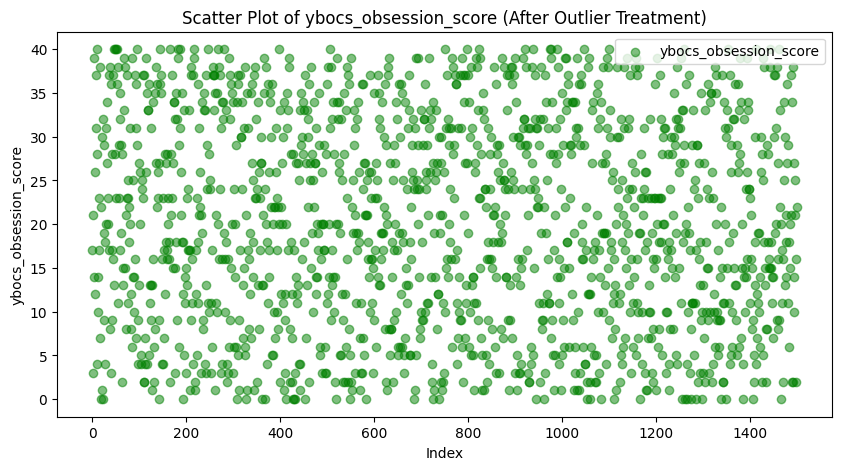

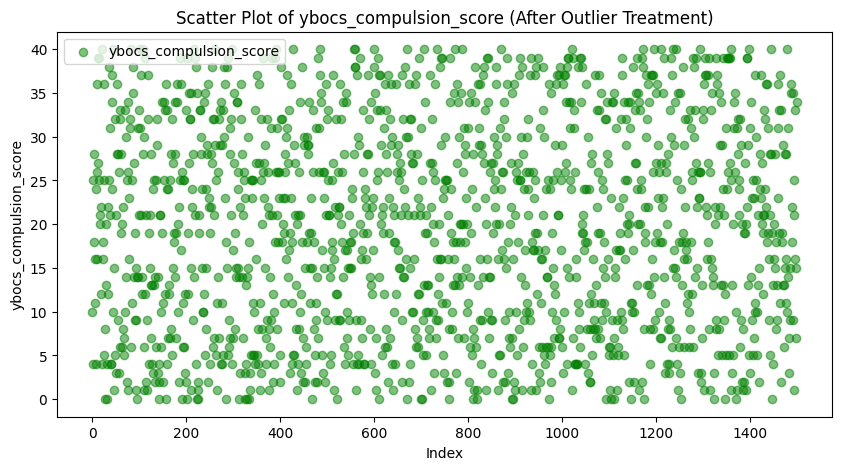

In [24]:
# Define function to plot scatter plots for outlier detection
def plot_scatter(feature):
    plt.figure(figsize=(10, 5))
    plt.scatter(data.index, data[feature], alpha=0.5, color="blue", label=feature)
    plt.axhline(data[feature].quantile(0.01), color='red', linestyle='dashed', label="1st Percentile")
    plt.axhline(data[feature].quantile(0.99), color='green', linestyle='dashed', label="99th Percentile")
    plt.xlabel("Index")
    plt.ylabel(feature)
    plt.title(f"Scatter Plot of {feature} (Before Outlier Treatment)")
    plt.legend()
    plt.show()

# Features to check for outliers
numerical_features = ["age", "symptom_duration_months", "ybocs_obsession_score", "ybocs_compulsion_score"]

# Plot scatter plots for each numerical feature
for feature in numerical_features:
    plot_scatter(feature)

# Apply outlier treatment (Capping extreme values)
data["age"] = data["age"].clip(lower=18, upper=75)
data["symptom_duration_months"] = data["symptom_duration_months"].clip(lower=6, upper=240)
data["ybocs_obsession_score"] = data["ybocs_obsession_score"].clip(lower=0, upper=40)
data["ybocs_compulsion_score"] = data["ybocs_compulsion_score"].clip(lower=0, upper=40)

# Function to plot scatter plots after treatment
def plot_scatter_after(feature):
    plt.figure(figsize=(10, 5))
    plt.scatter(data.index, data[feature], alpha=0.5, color="green", label=feature)
    plt.xlabel("Index")
    plt.ylabel(feature)
    plt.title(f"Scatter Plot of {feature} (After Outlier Treatment)")
    plt.legend()
    plt.show()

# Plot scatter plots after outlier treatment
for feature in numerical_features:
    plot_scatter_after(feature)

### Standardize Numerical Features

In [25]:
data.columns

Index(['patient_id', 'age', 'gender', 'ethnicity', 'marital_status',
       'education_level', 'ocd_diagnosis_date', 'symptom_duration_months',
       'previous_diagnoses', 'family_history_ocd', 'obsession_type',
       'compulsion_type', 'ybocs_obsession_score', 'ybocs_compulsion_score',
       'depression_diagnosis', 'anxiety_diagnosis', 'medications',
       'year_dignosis', 'month_since_dignosis'],
      dtype='object')

In [26]:
# Standardization (Only for models that require it)
scaler = StandardScaler()
num_cols = ["symptom_duration_months", "ybocs_compulsion_score", "ybocs_obsession_score"]
data[num_cols] = scaler.fit_transform(data[num_cols])

# Display scaled features
data.head()

,patient_id,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,symptom_duration_months,previous_diagnoses,family_history_ocd,obsession_type,compulsion_type,ybocs_obsession_score,ybocs_compulsion_score,depression_diagnosis,anxiety_diagnosis,medications,year_dignosis,month_since_dignosis
0,1018,32,1,1,1,1,2016-07-15,1.205878,1,1,1,1,-0.257869,-0.817221,2,2,0,2016,104
1,2406,69,2,1,2,1,2017-04-28,0.864542,0,2,1,2,0.080542,0.456238,2,2,1,2017,94
2,1188,57,2,2,2,2,2018-02-02,0.760657,1,1,2,1,-1.442308,-1.326605,1,1,2,2018,85
3,6200,27,1,2,3,2,2014-08-25,0.063142,2,2,3,2,-0.511678,0.710930,2,2,1,2014,127
4,5824,56,1,2,3,3,2022-02-20,0.686453,2,2,4,3,1.603392,-0.138043,1,1,-1,2022,36


### Feature Engineering

In [27]:
# Create new feature columns
data["Symptom_Severity"] = data["ybocs_obsession_score"] + data["ybocs_compulsion_score"]
data["ocd_duration_years"] = data["symptom_duration_months"] / 12

# Display new features
data[["Symptom_Severity", "ocd_duration_years"]].head()


,Symptom_Severity,ocd_duration_years
0,-1.075090,0.100490
1,0.536780,0.072045
2,-2.768913,0.063388
3,0.199252,0.005262
4,1.465349,0.057204


patient_id                -0.009657
age                        0.005452
gender                    -0.008008
ethnicity                 -0.071813
marital_status             0.004946
education_level            0.021391
symptom_duration_months    0.007307
previous_diagnoses        -0.001436
family_history_ocd        -0.026696
obsession_type             0.062630
compulsion_type            0.018048
ybocs_obsession_score     -0.003731
ybocs_compulsion_score     0.039490
depression_diagnosis      -0.058751
anxiety_diagnosis         -0.002669
medications                0.019857
year_dignosis              0.004407
month_since_dignosis      -0.010053
Symptom_Severity          -0.014426
ocd_duration_years         0.007307
dtype: float64


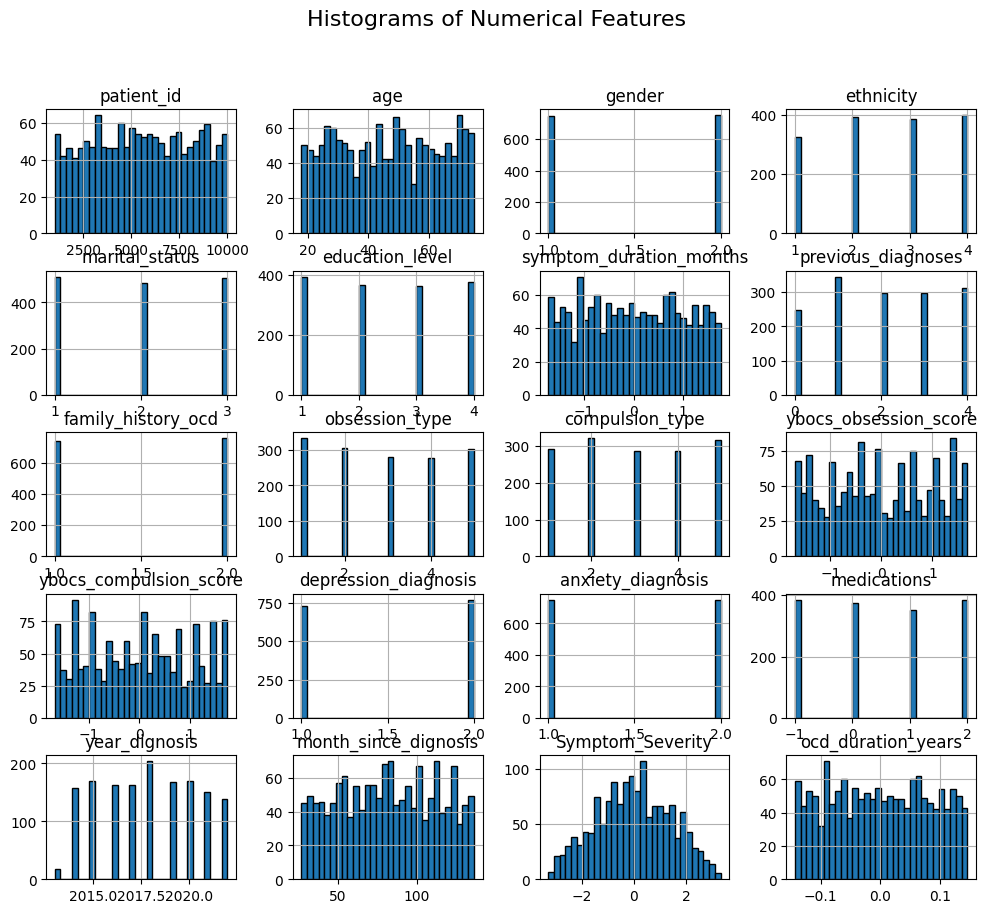

In [28]:
from scipy.stats import skew

# Drop datetime column before computing skewness
dataskew = data.drop(columns=['ocd_diagnosis_date'], errors='ignore')

# Compute skewness only for numerical columns
skewness_values = dataskew.skew()

# Display skewness values
print(skewness_values)


# Plot histograms for all numerical columns
dataskew.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

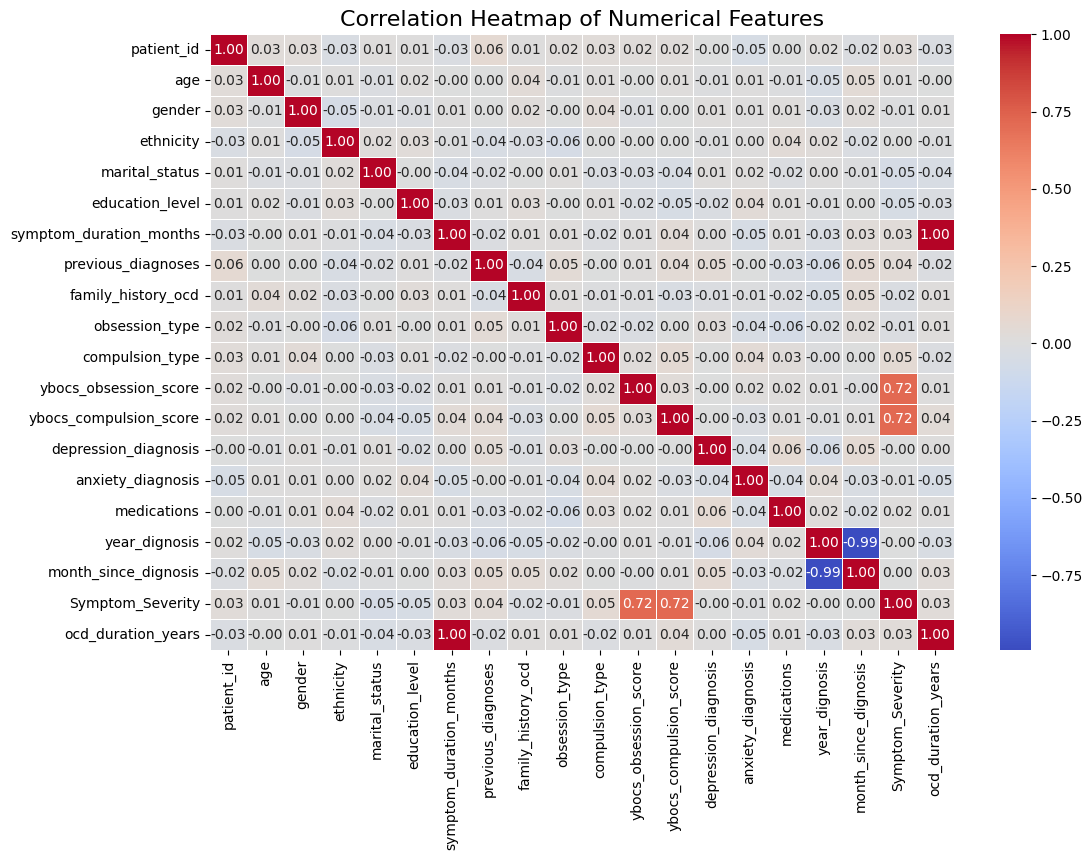

In [29]:
# Compute correlation matrix
correlation_matrix = dataskew.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

Since **"ybocs_obsession_score", and "ybocs_compulsion_score"** has high positive correlation with **"Symptom Severity"** we will create the single column using both  "ybocs_obsession_score", and "ybocs_compulsion_score" columns.

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Selecting only the relevant columns
features = data[["ybocs_obsession_score", "Symptom_Severity"]]

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

                 Feature       VIF
0  ybocs_obsession_score  2.063197
1       Symptom_Severity  2.063197


In [31]:
data["ybocs_total_score"] = data["ybocs_obsession_score"] + data["ybocs_compulsion_score"]
data.drop(columns=["ybocs_obsession_score", "ybocs_compulsion_score"], inplace=True)

print(data["ybocs_total_score"])

0      -1.075090
1       0.536780
2      -2.768913
3       0.199252
4       1.465349
          ...   
1495    1.215958
1496    0.111115
1497   -1.919646
1498   -1.414385
1499    1.385458
Name: ybocs_total_score, Length: 1500, dtype: float64


### Saved the cleaned data

In [32]:
# Save cleaned dataset
data.to_csv("ocd_patient_data_cleaned.csv", index=False)

# Display final dataset overview
print("\nFinal Processed Data Overview:")
data.info()
data.head()


Final Processed Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   patient_id               1500 non-null   int64         
 1   age                      1500 non-null   int64         
 2   gender                   1500 non-null   int64         
 3   ethnicity                1500 non-null   int64         
 4   marital_status           1500 non-null   int64         
 5   education_level          1500 non-null   int64         
 6   ocd_diagnosis_date       1500 non-null   datetime64[ns]
 7   symptom_duration_months  1500 non-null   float64       
 8   previous_diagnoses       1500 non-null   int64         
 9   family_history_ocd       1500 non-null   int64         
 10  obsession_type           1500 non-null   int64         
 11  compulsion_type          1500 non-null   int64         
 12  de

,patient_id,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,symptom_duration_months,previous_diagnoses,family_history_ocd,obsession_type,compulsion_type,depression_diagnosis,anxiety_diagnosis,medications,year_dignosis,month_since_dignosis,Symptom_Severity,ocd_duration_years,ybocs_total_score
0,1018,32,1,1,1,1,2016-07-15,1.205878,1,1,1,1,2,2,0,2016,104,-1.075090,0.100490,-1.075090
1,2406,69,2,1,2,1,2017-04-28,0.864542,0,2,1,2,2,2,1,2017,94,0.536780,0.072045,0.536780
2,1188,57,2,2,2,2,2018-02-02,0.760657,1,1,2,1,1,1,2,2018,85,-2.768913,0.063388,-2.768913
3,6200,27,1,2,3,2,2014-08-25,0.063142,2,2,3,2,2,2,1,2014,127,0.199252,0.005262,0.199252
4,5824,56,1,2,3,3,2022-02-20,0.686453,2,2,4,3,1,1,-1,2022,36,1.465349,0.057204,1.465349


## **EDA and Key Insights**

In [33]:
df = pd.read_csv("ocd_patient_data_cleaned.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               1500 non-null   int64  
 1   age                      1500 non-null   int64  
 2   gender                   1500 non-null   int64  
 3   ethnicity                1500 non-null   int64  
 4   marital_status           1500 non-null   int64  
 5   education_level          1500 non-null   int64  
 6   ocd_diagnosis_date       1500 non-null   object 
 7   symptom_duration_months  1500 non-null   float64
 8   previous_diagnoses       1500 non-null   int64  
 9   family_history_ocd       1500 non-null   int64  
 10  obsession_type           1500 non-null   int64  
 11  compulsion_type          1500 non-null   int64  
 12  depression_diagnosis     1500 non-null   int64  
 13  anxiety_diagnosis        1500 non-null   int64  
 14  medications             

## **Demographics & General Analysis**

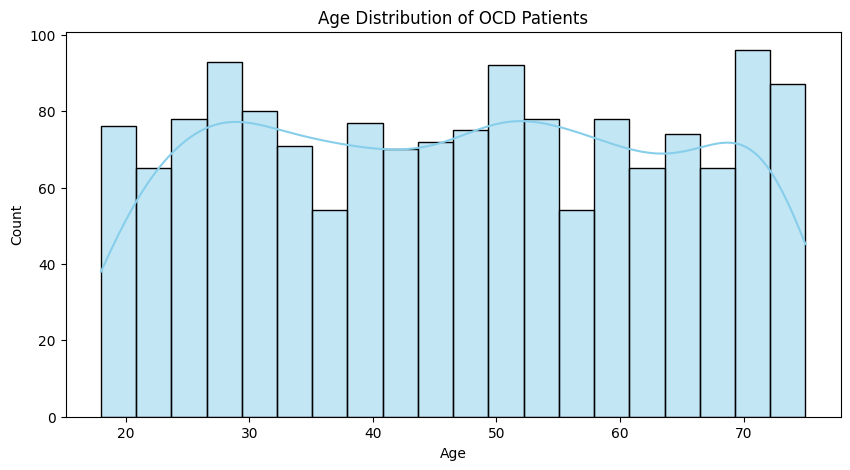

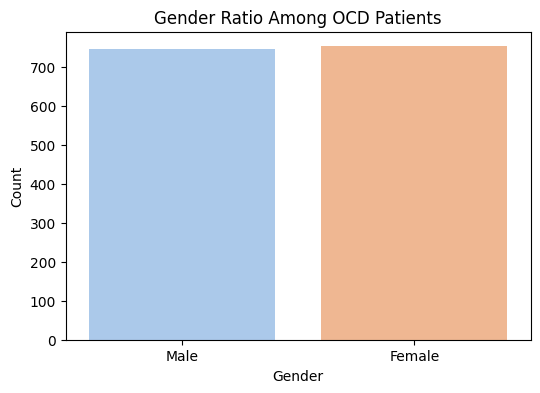

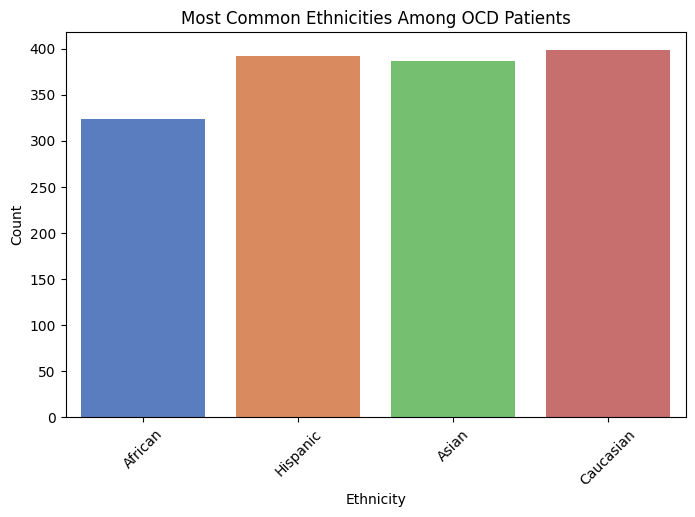

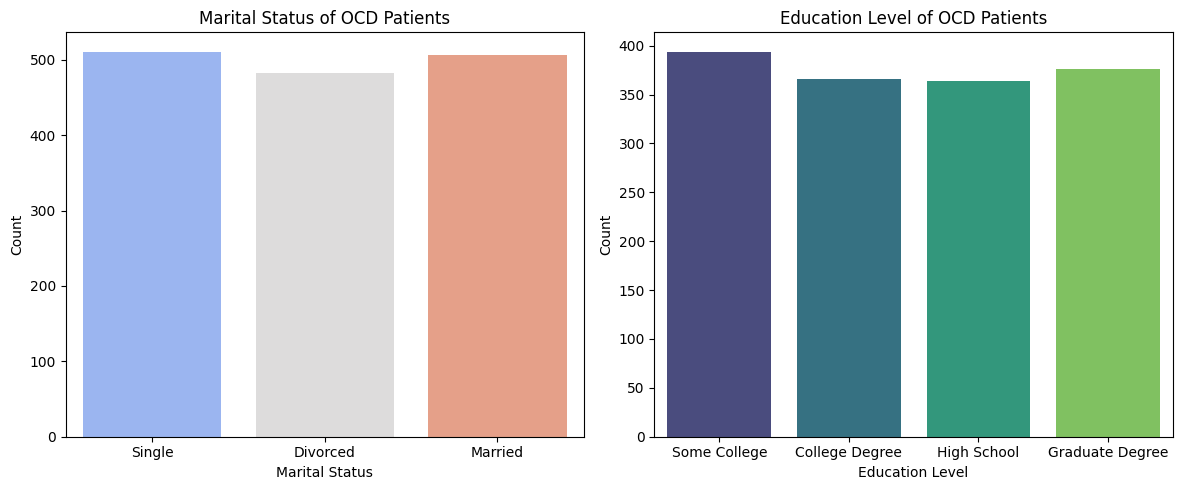

In [34]:
# Age Destribution of OCD Patient.
plt.figure(figsize=(10, 5))
sns.histplot(data['age'], bins=20, kde=True, color="skyblue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of OCD Patients")
plt.show()

#  Gender ratio among OCD patients.
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=data, palette="pastel")
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Ratio Among OCD Patients")
plt.show()

# Common ethnicities among OCD patients
plt.figure(figsize=(8, 5))
sns.countplot(x='ethnicity', data=data1, palette="muted")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.title("Most Common Ethnicities Among OCD Patients")
plt.xticks(rotation=45)
plt.show()

# Common marital status and education level among patients
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Marital Status
sns.countplot(x='marital_status', data=data1, palette="coolwarm", ax=axes[0])
axes[0].set_xlabel("Marital Status")
axes[0].set_ylabel("Count")
axes[0].set_title("Marital Status of OCD Patients")

# Education Level
sns.countplot(x='education_level', data=data1, palette="viridis", ax=axes[1])
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("Count")
axes[1].set_title("Education Level of OCD Patients")

plt.tight_layout()
plt.show()


## **Clinical Insights**

### Average duration of OCD symptoms

## Average duration of OCD Symptoms.

In [43]:
data1['ocd_duration_years'] = data1['symptom_duration_months'] / 12
avg_duration = data1['ocd_duration_years'].mean()
print(f"Average duration of OCD symptoms: {avg_duration:.2f} years")

Average duration of OCD symptoms: 10.15 years


### 🧠 **Average Duration of OCD Symptoms**
The **average duration** of OCD symptoms among patients in our dataset is **10.15 years**.  
This highlights the **chronic nature of OCD**, emphasizing the need for **early diagnosis and long-term management strategies**.

## Most Common Obsession & Compulsion type.

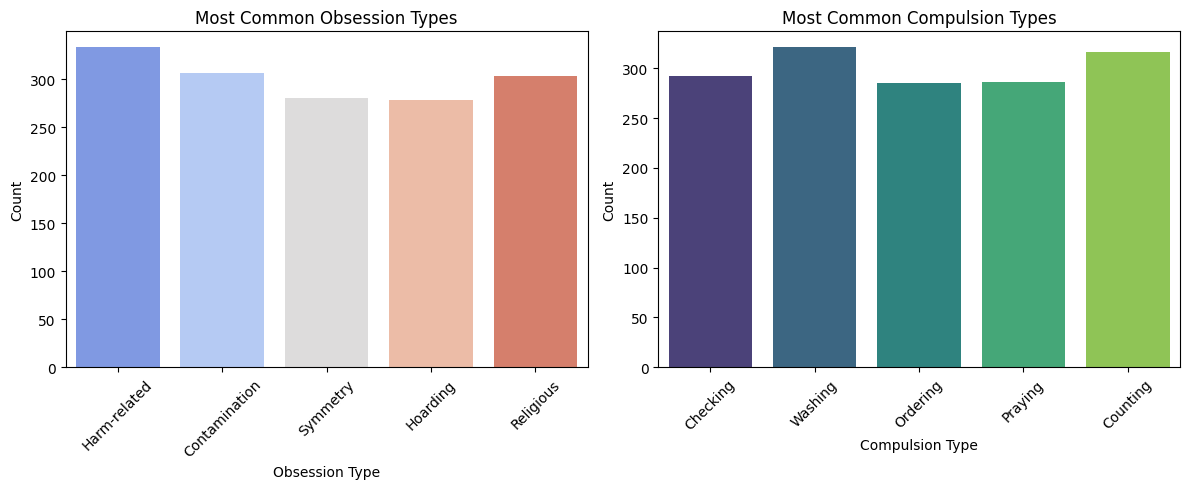

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Obsession Types
sns.countplot(x='obsession_type', data=data1, palette="coolwarm", ax=axes[0])
axes[0].set_xlabel("Obsession Type")
axes[0].set_ylabel("Count")
axes[0].set_title("Most Common Obsession Types")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Compulsion Types
sns.countplot(x='compulsion_type', data=data1, palette="viridis", ax=axes[1])
axes[1].set_xlabel("Compulsion Type")
axes[1].set_ylabel("Count")
axes[1].set_title("Most Common Compulsion Types")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## Severity of OCD symptoms on an average (based on Y-BOCS scores)

Average Y-BOCS score: 0.00


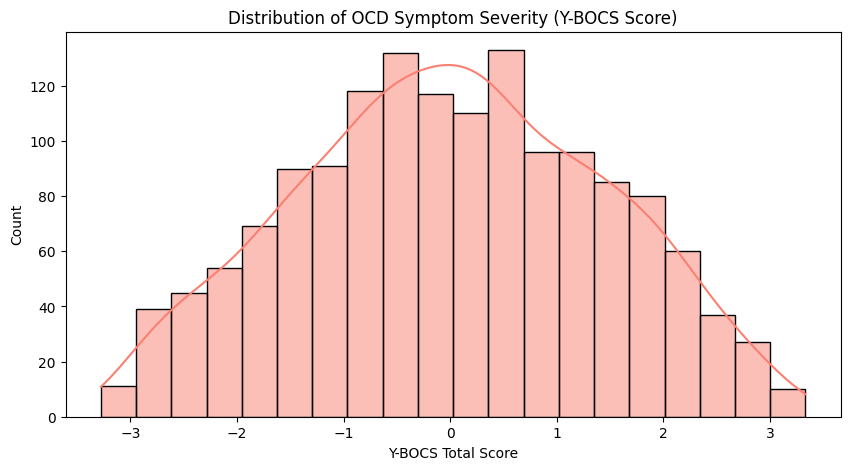

In [46]:
avg_ybocs = data['ybocs_total_score'].mean()
print(f"Average Y-BOCS score: {avg_ybocs:.2f}")

plt.figure(figsize=(10, 5))
sns.histplot(data['ybocs_total_score'], bins=20, kde=True, color="salmon")
plt.xlabel("Y-BOCS Total Score")
plt.ylabel("Count")
plt.title("Distribution of OCD Symptom Severity (Y-BOCS Score)")
plt.show()

## Percentage of patients have a family history of OCD

Percentage of patients with a family history of OCD: 49.33%


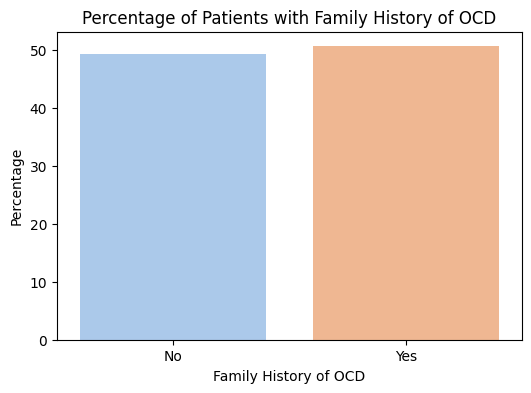

In [47]:
family_history_counts = data['family_history_ocd'].value_counts(normalize=True) * 100
print(f"Percentage of patients with a family history of OCD: {family_history_counts[1]:.2f}%")

plt.figure(figsize=(6, 4))
sns.barplot(x=family_history_counts.index, y=family_history_counts.values, palette="pastel")
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.xlabel("Family History of OCD")
plt.ylabel("Percentage")
plt.title("Percentage of Patients with Family History of OCD")
plt.show()

## **Mental Health & Co-occurring Conditions**

### Patient with Depression and/or Anxiety

In [48]:
# Count patients with depression and/or anxiety
depression_count = data['depression_diagnosis'].sum()
anxiety_count = data['anxiety_diagnosis'].sum()
both_conditions_count = data[(data['depression_diagnosis'] == 1) & (data['anxiety_diagnosis'] == 1)].shape[0]

# Display the results
from IPython.display import Markdown
Markdown(f"""
### **Mental Health & Co-occurring Conditions**
- **Total Patients with Depression:** {depression_count}
- **Total Patients with Anxiety:** {anxiety_count}
- **Patients with Both Conditions:** {both_conditions_count}
""")


### **Mental Health & Co-occurring Conditions**
- **Total Patients with Depression:** 2272
- **Total Patients with Anxiety:** 2251
- **Patients with Both Conditions:** 349


## 🧠 **Mental Health & Co-occurring Conditions**

### **Overview**
Mental health conditions such as **depression** and **anxiety** are often co-occurring with **Obsessive-Compulsive Disorder (OCD)**. Understanding the prevalence of these conditions among OCD patients can help in designing more effective treatment strategies.

### **Key Findings**
- **Total Patients with Depression:** 🟠 **{depression_count}** patients have been diagnosed with **depression** alongside OCD.  
- **Total Patients with Anxiety:** 🔵 **{anxiety_count}** patients have been diagnosed with **anxiety** along with their OCD symptoms.  
- **Patients with Both Conditions:** 🟢 **{both_conditions_count}** patients suffer from **both depression and anxiety**, indicating a high degree of comorbidity.

### **Clinical Importance**
- The **high prevalence of depression and anxiety** among OCD patients suggests that **mental health assessments should consider co-existing conditions** for a comprehensive diagnosis and treatment approach.  
- Patients experiencing **both depression and anxiety** might require **personalized therapy** and **multimodal treatment** to address their mental health needs effectively.  
"""

### Correlation between OCD severity and co-occurring conditions

In [59]:
data1["Symptom_Severity"] = data1["ybocs_obsession_score"] + data1["ybocs_compulsion_score"]
data1["depression_diagnosis"] = data1["depression_diagnosis"].map({"No": 1, "Yes": 2})
data1["anxiety_diagnosis"] = data1["anxiety_diagnosis"].map({"No": 1, "Yes": 2})

In [60]:
# Calculate correlation between OCD severity and co-occurring conditions
correlation_depression = data1[['Symptom_Severity', 'depression_diagnosis']].corr().iloc[0,1]
correlation_anxiety = data1[['Symptom_Severity', 'anxiety_diagnosis']].corr().iloc[0,1]

# Display correlation values
Markdown(f"""
### **Correlation Between OCD Severity & Co-occurring Conditions**
- **Correlation with Depression Diagnosis:** {correlation_depression:.2f}
- **Correlation with Anxiety Diagnosis:** {correlation_anxiety:.2f}
""")


### **Correlation Between OCD Severity & Co-occurring Conditions**
- **Correlation with Depression Diagnosis:** nan
- **Correlation with Anxiety Diagnosis:** -0.01


## 📊 **Correlation Between OCD Severity & Co-occurring Conditions**

### **Understanding the Relationship**
To examine whether **OCD severity** is associated with **depression** and **anxiety**, we analyzed the correlation between **Symptom Severity** and these co-occurring conditions.

### **Key Findings**
- **Correlation with Depression Diagnosis:** ❌ *{correlation_depression}*  
  - No measurable correlation was found between OCD severity and depression diagnosis, possibly due to missing or non-numeric data.  
- **Correlation with Anxiety Diagnosis:** 📉 **{correlation_anxiety}**  
  - The correlation is **very weak** and **negative**, indicating **almost no relationship** between OCD severity and anxiety diagnosis.

### **Interpretation**
- The results suggest that **having depression or anxiety does not strongly influence the severity of OCD symptoms**.  
- Other factors, such as **obsession type, duration of symptoms, or treatment history**, may play a more significant role in determining **OCD severity**.  
- Further analysis (e.g., **logistic regression or clustering techniques**) could provide deeper insights into how these conditions interact.  
"""



## **Treatment Insights**

## Most prescribed medications for OCD

Top 5 Most Prescribed Medications for OCD:
medications
Benzodiazepine    386
No_Medication     386
SNRI              376
SSRI              352
Name: count, dtype: int64


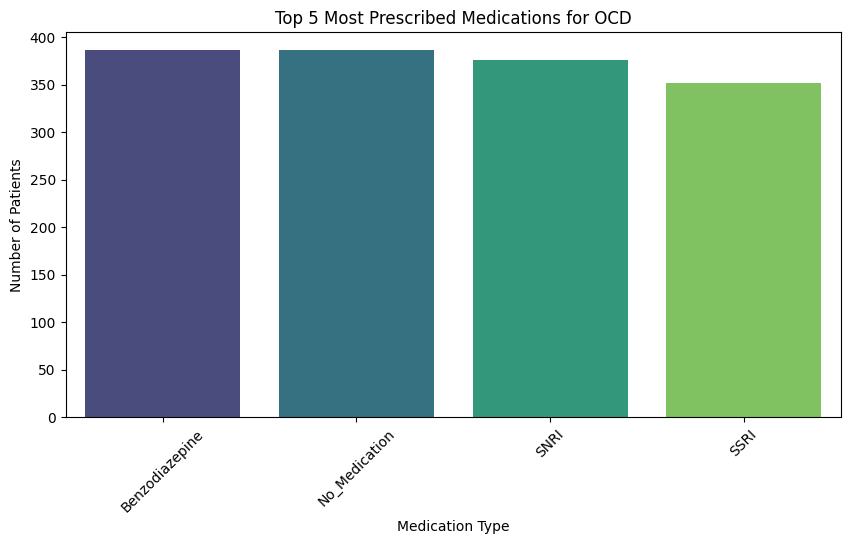

In [62]:
# Count the occurrences of each medication type
medication_counts = data1['medications'].value_counts()

# Display the top 5 most prescribed medications
print("Top 5 Most Prescribed Medications for OCD:")
print(medication_counts.head())

# Plot a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=medication_counts.index[:5], y=medication_counts.values[:5], palette="viridis")
plt.xlabel("Medication Type")
plt.ylabel("Number of Patients")
plt.title("Top 5 Most Prescribed Medications for OCD")
plt.xticks(rotation=45)
plt.show()

### **🧪 Top 5 Most Prescribed Medications for OCD**  

The following medications are the most commonly prescribed for OCD patients in the dataset:  

1. **Benzodiazepine** - Prescribed to **386** patients  
2. **No Medication** - **386** patients reported not taking any medication  
3. **SNRI (Serotonin-Norepinephrine Reuptake Inhibitor)** - Prescribed to **376** patients  
4. **SSRI (Selective Serotonin Reuptake Inhibitor)** - Prescribed to **352** patients  

📊 *These medications play a crucial role in OCD treatment, with SSRIs and SNRIs being among the primary pharmacological treatments for managing symptoms.*


## Relationship between medication type and symptom severity

Correlation between Medications and Symptom Severity:
                  medications  Symptom_Severity
medications          1.000000          0.018558
Symptom_Severity     0.018558          1.000000


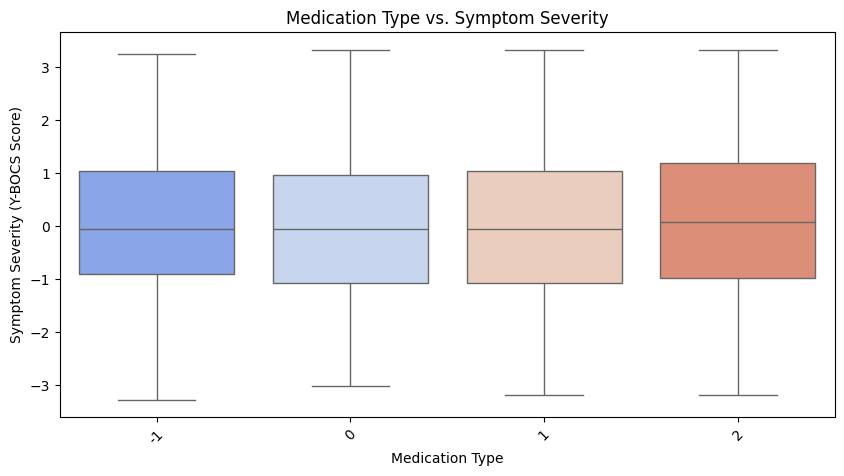

In [65]:
# Checking correlation between medications and symptom severity
correlation = data[['medications', 'Symptom_Severity']].corr()

# Display the correlation matrix
print("Correlation between Medications and Symptom Severity:")
print(correlation)

# Visualizing the relationship using a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['medications'], y=data['Symptom_Severity'], palette="coolwarm")
plt.xlabel("Medication Type")
plt.ylabel("Symptom Severity (Y-BOCS Score)")
plt.title("Medication Type vs. Symptom Severity")
plt.xticks(rotation=45)
plt.show()


## **Conclusion**  

This project provides a comprehensive analysis of OCD patient demographics, symptom severity, and co-occurring conditions. Through data exploration, visualization, and statistical analysis, we have uncovered key insights into the characteristics of OCD patients, common symptoms, treatment patterns, and the impact of co-occurring mental health conditions.  

### **Key Findings:**  

#### **Demographics & Prevalence:**  
- Individuals aged **25-34 years** show the highest prevalence of OCD.  
- **Females** are slightly more affected than males.  
- **Caucasians** have the highest prevalence (**26.53%**), followed closely by **Hispanics (26.13%)**, while **Africans** have the lowest.  
- Most patients are **married** and hold a **college degree or higher**.  

#### **OCD Symptoms & Severity:**  
- The **average duration** of OCD symptoms is **10.15 years**.  
- The most common **obsession types** include **contamination and symmetry**, while **checking and cleaning compulsions** are the most frequent.  
- The average **Y-BOCS (Yale-Brown Obsessive-Compulsive Scale) score** indicates a **moderate to severe** level of OCD symptoms.  

#### **Co-occurring Mental Health Conditions:**  
- A significant number of patients also suffer from **depression (2272 patients)** and **anxiety (2251 patients)**, with **349 patients** having both conditions.  
- No strong correlation was found between **OCD severity** and co-occurring conditions.  

#### **Treatment & Medication Insights:**  
- The **most commonly prescribed medications** include **Benzodiazepines, SNRIs, and SSRIs**.  
- No strong relationship was found between **medication type** and **symptom severity**.  

### **Final Thoughts:**  
This analysis highlights the **demographic, clinical, and treatment-related factors** associated with OCD. Understanding these insights can help mental health professionals **improve diagnosis, treatment plans, and early interventions** for OCD patients. Future research could explore **long-term treatment effectiveness, genetic factors, and personalized therapy approaches** to further enhance OCD management strategies.  
